In [1]:
import tensorflow as tf
import keras
tf.__version__

'2.9.1'

In [2]:
import numpy as np
import os
import random
from PIL import Image
import itertools
from tqdm import tqdm
from tensorflow.keras import layers

import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
import scipy.signal

In [6]:
# from libpysal.weights import lat2W
# from esda.moran import Moran
# from scipy.fft import fft2, ifft2, fftshift, ifftshift

In [5]:
from conv_settings import Conv
from initializer_settings import NovelMethod, GlorotNormal, RandomNormal

In [4]:
# Stops TF from taking up all available GPU memory at runtime
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [7]:
from custom_models import create_autoencoder
model = create_autoencoder((32,32,1),7,3,'NovelMethod')

In [8]:
layers = [layer.weights for layer in model.layers if layer.name.startswith('c')]
kernels = [kernel.numpy() for kernel in layers[0]]
imgs = [kernels[0][:,:,:,i] for i in range(kernels[0].shape[3])]

In [34]:
# NovelMethod(7,3)((32,32,1))

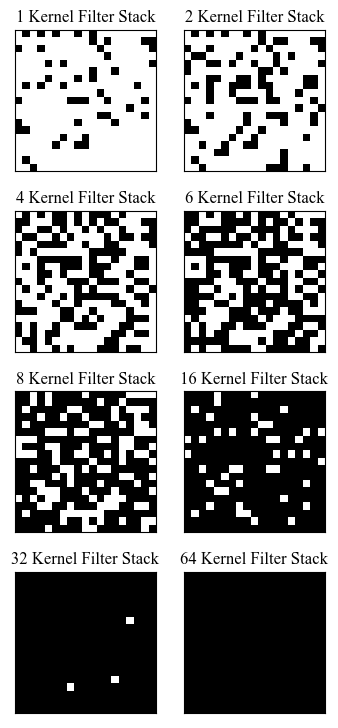

In [50]:
fig, axs = plt.subplots(4,2,figsize=(4,9))
axs = np.array(axs)
plt.rcParams["font.family"] = "Times New Roman"
for ax, count in zip(axs.reshape(-1),[1,2,4,6,8,16,32,64]):
    vals = np.mean(imgs[:count],axis=0)
    nonzero = np.where(vals!=0,1,0)
    ax.imshow(nonzero,cmap='binary',vmin=0,vmax=1) #cmap='bwr',vmin=-img.std()/count,vmax=img.std()/count
    # ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'{count} Kernel Filter Stack')
# fig.savefig('NovelMethod_filter.png',dpi=500)
# plt.tight_layout()
plt.show()

In [ ]:
for k,shape in zip([3,5,7],[9,13,19]):
    output = []
    for x in range(64):
        stack = np.zeros(shape*shape)
        holding = []
        for i in range(x):
            blank = np.zeros(shape*shape)
            while np.sum(blank)<k**2:
                rand = random.randint(0,shape*shape-1)
                blank[rand] = 1
            holding.append(blank)
        stack = np.mean(holding,axis=0)
        stack = np.where(stack!=0,1,0)
        print(np.sum(stack))

In [ ]:
fig, axs = plt.subplots(8,8,figsize=(15,15))
axs = np.array(axs)
for ax in axs.reshape(-1):
    arr = np.zeros((9,9))
    for x in range(9):
        for y in range(9):
            if x%2==0 and y%2==0:
                arr[x,y]=random.random()-0.5
    ax.imshow(arr/2,cmap='bwr',vmin=-arr.std(),vmax=arr.std())
    # ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
# fig.savefig('Conventional_examples.png')
plt.tight_layout()
plt.show()

In [111]:
import itertools
size = 9
blank = np.zeros((size,size))
for x,y in list(itertools.product(range(1,size-1),range(1,size-1))):
    for i,j in list(itertools.product(range(-1,2),range(-1,2))):
        blank[x+i,y+j]+=1


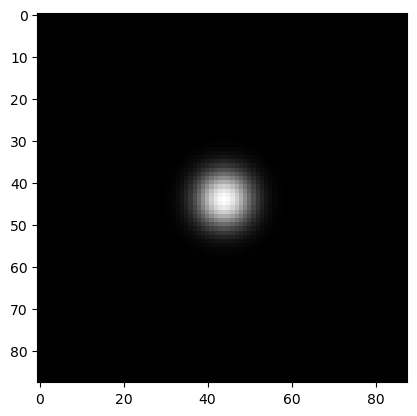

In [74]:
size = 128
layer = np.zeros((size,size))
layer[size//2,size//2] = 1
holding = []
kernel = np.ones((5,5))
for i in range(10):
    if i == 0:
        conv = scipy.signal.convolve2d(layer,kernel,'valid')
        holding.append(conv)
    else:
        conv = scipy.signal.convolve2d(conv,kernel,'valid')
        holding.append(conv)
plt.imshow(holding[-1],cmap='gray')

In [146]:
def get_novel(k,d,shape):
    stddev = 0.05 
    dilation = d
    kernel = k
    nonzero_count = k**2
    dilated_height = kernel-(dilation-1)+(kernel*(dilation-1))
    dilated_width = kernel-(dilation-1)+(kernel*(dilation-1))
    kernel_extent = dilated_height*dilated_width

    def get_novel_sparse_tensor():
        values = tf.random.truncated_normal(shape=[shape[0],shape[1]],
                                         mean=0.0,stddev=stddev).numpy().flatten()
        nonzero_indices = set()
        center_point = kernel_extent//2
        if kernel_extent % 2 == 1: center_point += 1
        nonzero_indices.add(center_point)
        while len(nonzero_indices) < nonzero_count:
            index = random.randint(0,kernel_extent-1)
            if index not in nonzero_indices: nonzero_indices.add(index)
            elif len(nonzero_indices) == nonzero_count: break
            arr = np.zeros(kernel_extent)
            for location, value in zip(list(nonzero_indices),values):
                arr[location-1] = value
            tensor = arr.reshape(dilated_height,dilated_width).astype('float32')
        return tensor

    if len(shape)>2:
        out_channel_list = []
        for axis in range(shape[2]):
            if len(shape)==4:
                out_batch_list = []
                for axis in range(shape[3]):
                    batch_tensor = get_novel_sparse_tensor()
                    out_batch_list.append(batch_tensor)
                channel_tensor = np.stack(out_batch_list, axis=-1)
            else:
                channel_tensor = get_novel_sparse_tensor()
            out_channel_list.append(channel_tensor)      
        final_out = np.stack(out_channel_list, axis=-2)
        return tf.convert_to_tensor(final_out)
    else:
        return tf.convert_to_tensor(get_novel_sparse_tensor())

In [260]:
def visualize_stack(size,k,d,depth,filters,typex):

    top_layer = np.zeros((size,size))
    top_layer[size//2,size//2] = 1
    holding = []

    for i in range(depth):
        if i == 0:
            conv = top_layer
        if typex != 'novel' or d == 1:
            extent = k-(d-1)+(k*(d-1))
            kernel = np.zeros((extent,extent)).flatten()
            for i,x in enumerate(kernel):
                if i % d == 0:
                    kernel[i] = 1
            kernel = kernel.reshape((extent,extent))
            for x in range(extent):
                for y in range(extent):
                    if x % d != 0 or y % d != 0:
                        kernel[x,y] = 0
            conv = scipy.signal.convolve2d(conv,kernel,'valid')
            holding.append(conv)
        else:
            zhold = []
            for z in range(filters):
                novel_kernel = get_novel(k,d,(k,k)).numpy()
                zhold.append(np.add(np.abs(novel_kernel),1))
            kernel = np.abs(np.max(zhold,axis=0))
            conv = scipy.signal.convolve2d(conv,kernel,'valid')
            holding.append(conv)
    return holding[-1]

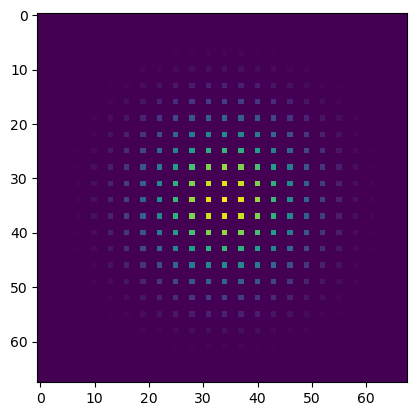

In [320]:
output = visualize_stack(128,5,3,5,6,'g')
plt.imshow(output) #,cmap='gray'

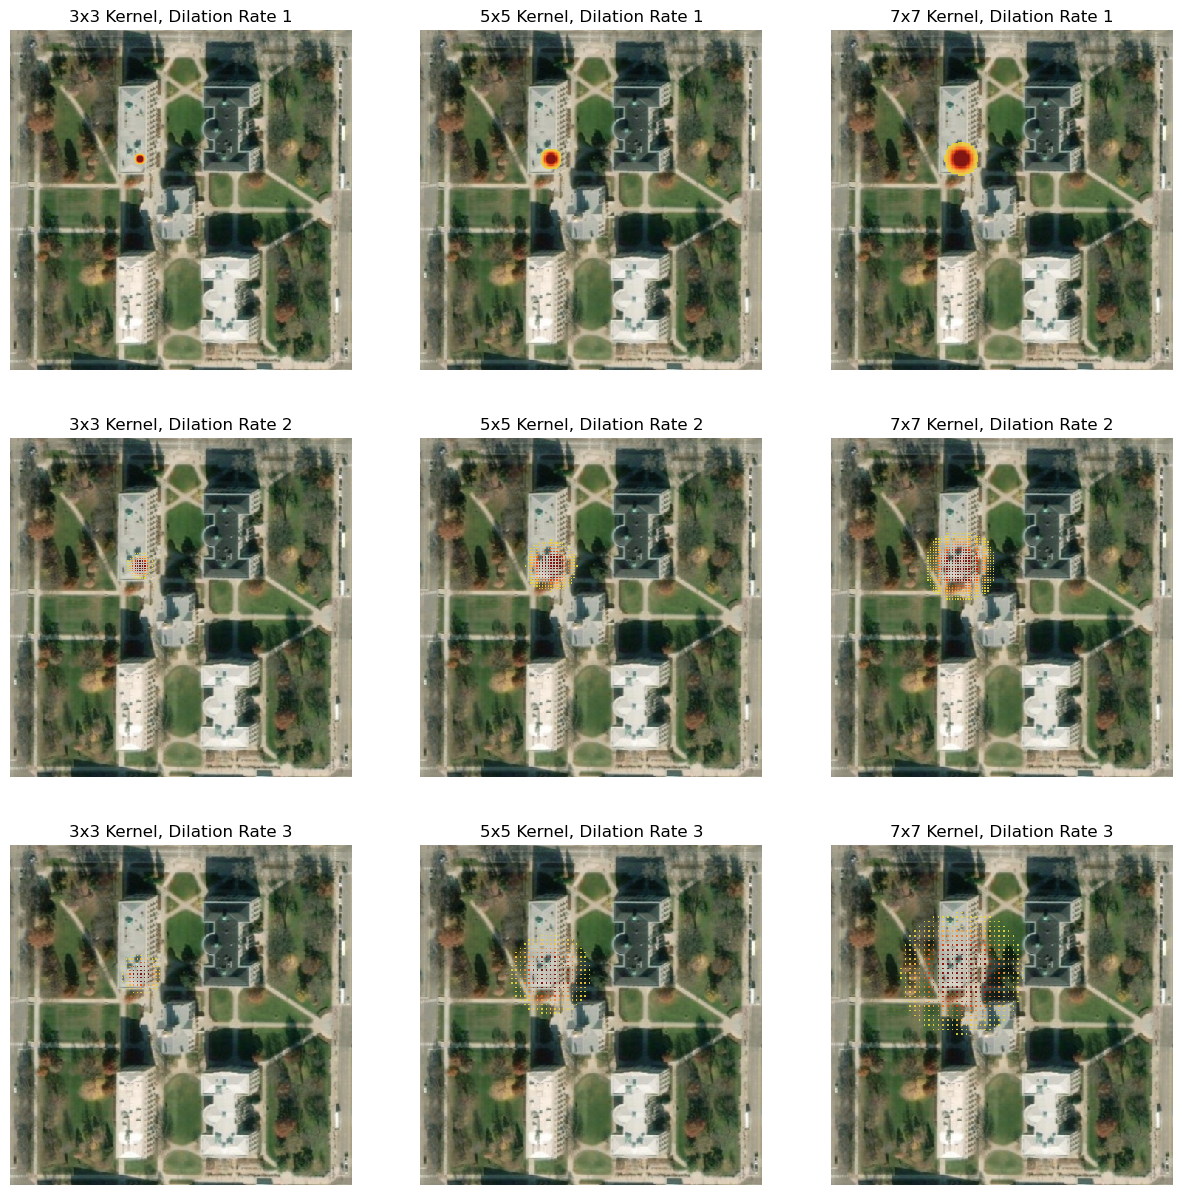

In [321]:
landsat = Image.open(r"C:\Users\namacdon\Documents\GitHub\receptive_fields\Images\pentacrest.jpg")
arr = np.array(landsat)
scaled = arr/255.0
# plt.imshow(scaled)

fig, axs = plt.subplots(3,3,figsize=FIGSIZE)
axs = np.array(axs)
for ax, settings, title in zip(axs.reshape(-1), combinations.values(), combinations.keys()):
    extent = (175-settings[2]*2,175+settings[2]*2,175-settings[2]*2,175+settings[2]*2)
    output = visualize_stack((extent[1]-extent[0]),settings[0],settings[1],5,6,'g')
    img = np.ma.masked_where(output<output.std()*0.1,output)
    ax.imshow(scaled,interpolation='none')
    ax.imshow(img, cmap='turbo', vmin=-img.std()*3,vmax=img.std()*2, alpha=0.7,interpolation='none',extent=extent)
    ax.imshow(scaled,interpolation='none',alpha=0.1)
    ax.set_title(title)
    ax.axis("off")
    ax.grid(True)
# fig.savefig('Conventional_5Layers.png')
plt.show()

### Example Models

### Establish Hyperparameters

In [202]:
channels = 1
im_size = 32
FIGSIZE = (15,15)

#### Applying Novel Method to CNN

In [204]:
class encoder(tf.keras.Model):
    def __init__(self,kernel,dilation,init):
        super(encoder,self).__init__()    
        self.conv1 = Conv(filters=1, kernel_size=(kernel,kernel), strides=(1,1),
                          padding='same',dilation_rate=(dilation,dilation),
                          kernel_initializer=init, name='conv2D_1')
        self.maxpool = tf.keras.layers.MaxPool2D((2,2))
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.conv1(x)
        return self.conv1(x)

class decoder(tf.keras.Model):
    def __init__(self,kernel,dilation,init):
        super(decoder,self).__init__()
        self.conv1 = Conv(filters=1, kernel_size=(kernel,kernel),strides=(1,1),
                          padding='same',dilation_rate=(dilation,dilation),
                          kernel_initializer=init, name='deconv2D_1')
        self.upsampling = keras.layers.UpSampling2D((2, 2), name="up_samp")
        
    def call(self, inputs):
        x = self.upsampling(inputs)
        x = self.upsampling(x)
        return self.upsampling(x)
    
class autoencoder(tf.keras.Model):
    def __init__(self, kernel_size = 3, dilation = 1, weight_initialization = 'GlorotNormal', num_filters=32):
        super(autoencoder, self).__init__()        
        # Check for issues with kernel or dilation values.
        if (kernel_size%2)-1 != 0 or kernel_size<3 or dilation<1:
            print('error')    
        # Gather information for the weight initialization scheme
        if weight_initialization == 'NovelMethod':
            init = NovelMethod(kernel_size,dilation)
            kernel_size = kernel_size-(dilation-1)+(kernel_size*(dilation-1))
            dilation = 1
        elif weight_initialization == 'RandomUniform':
            init = tf.keras.initializers.RandomUniform(minval=0., maxval=1.)
        else:
            init = tf.keras.initializers.GlorotNormal()
            
        self.encoder = encoder(kernel_size,dilation,init)
        self.decoder = decoder(kernel_size,dilation,init)

    def call(self, inputs):
        encoded = self.encoder(inputs)
        decoded = self.decoder(encoded)
        return decoded

model = autoencoder(5,3,'RandomUniform')
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='mean_absolute_error',
    metrics=['mean_absolute_error'])
model.build([1, im_size,im_size,channels])
model.summary()

Model: "autoencoder_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_1 (encoder)         multiple                  26        
                                                                 
 decoder_1 (decoder)         multiple                  0         
                                                                 
Total params: 26
Trainable params: 26
Non-trainable params: 0
_________________________________________________________________


In [205]:
def create_autoencoder(shape, kernel_size, dilation, weight_init,num_filters=2):
    
    kernel_size, dilation, init = hyperparameters(kernel_size, dilation, weight_init)
    global zero_loc
    zero_loc = {}
    
    input_img = keras.Input(shape=(shape[0], shape[1], shape[2]))
    x = Conv(filters=1, kernel_size=(kernel_size,kernel_size), strides=(1,1),
                 padding='same',dilation_rate=(dilation,dilation),kernel_initializer=init,
                 kernel_constraint=Zeroizer(init,f'conv2D_64e'),name=f'conv2D_64e')(input_img)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.MaxPool2D((2,2))(x)
    zah=1
    for filters in [num_filters]:
        x = Conv(filters=filters, kernel_size=(kernel_size,kernel_size), strides=(1,1),
                 padding='same',dilation_rate=(dilation,dilation),kernel_initializer=init,
                 kernel_constraint=Zeroizer(init,f'conv2D_{zah}e'),name=f'conv2D_{zah}e')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.LeakyReLU()(x)
        x = keras.layers.MaxPool2D((2,2))(x)
        zah+=1
    
    for filters in [num_filters,num_filters]:
        x = Conv(filters=filters, kernel_size=(kernel_size,kernel_size),strides=(1,1),
                 padding='same',dilation_rate=(dilation,dilation),kernel_initializer=init,
                 kernel_constraint=Zeroizer(init,f'conv2D_{zah}e'),name=f'conv2D_{zah}d')(x)
        x = keras.layers.UpSampling2D((2, 2))(x)
        x = keras.layers.BatchNormalization(momentum=0.5)(x)
        x = keras.layers.LeakyReLU()(x)
        zah+=1
    decoded = keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    model = keras.Model(input_img, decoded)

    if weight_init == "NovelMethod" and zero_loc == {}:
        for layer in model.layers:
            if layer.name.startswith("conv"):
                zero_loc[f'{layer.name}'] = layer.get_weights()
    for key, value in zero_loc.items():
        zeros = abs(value[0]) > 0.000001
        zero_loc[key] = np.where(zeros==True,1,0)

    return model

class Zeroizer(tf.keras.constraints.Constraint):
    def __init__(self, scheme, name):
        self.scheme = scheme
        self.name = name

    def __call__(self, w):
        if self.scheme == "NovelMethod":
            try:
                zeros = zero_loc[self.name][0]
                return w * zeros
            except:
                pass
        else:
            return w


def hyperparameters(kernel_size, dilation, weight_init):
    if (kernel_size % 2)-1 != 0 or kernel_size < 3 or dilation < 1:
        print('error')
    if weight_init == 'NovelMethod':
        init = NovelMethod(kernel_size, dilation)
        kernel_size = kernel_size-(dilation-1)+(kernel_size*(dilation-1))
        dilation = 1
    elif weight_init == 'RandomUniform':
        init = RandomUniform
    else:
        init = GlorotNormal
    return kernel_size, dilation, init

In [206]:
combinations = {
    '3x3 Kernel, Dilation Rate 1': [3,1,7],
    '5x5 Kernel, Dilation Rate 1': [5,1,13],
    '7x7 Kernel, Dilation Rate 1': [7,1,17],
    '3x3 Kernel, Dilation Rate 2': [3,2,13],
    '5x5 Kernel, Dilation Rate 2': [5,2,21],
    '7x7 Kernel, Dilation Rate 2': [7,2,33],
    '3x3 Kernel, Dilation Rate 3': [3,3,19],
    '5x5 Kernel, Dilation Rate 3': [5,3,31],
    '7x7 Kernel, Dilation Rate 3': [7,3,43]
}
KERNELS = [3,5,7]
DILATIONS = [1,2,3]
WEIGHTS = ["GlorotNormal","NovelMethod"]
combinations2 = list(itertools.product(KERNELS,DILATIONS,WEIGHTS))
i = 0
for x in combinations.values():
    combinations2[i] = combinations2[i]+(x[2],)
    combinations2[i+1] = combinations2[i+1]+(x[2],)
    i+=2

In [207]:
# Dummy image
dummy_image = np.zeros([1,im_size,im_size,channels])
for h in range(im_size):
    for w in range(im_size):
        if h == im_size//2 and w == im_size//2:
            dummy_image[:,h,w,:] = 1
# # plt.figure(figsize=(5,5));
# # plt.imshow(arr[0,:,:,:]);

def get_dummy(scale):
    dummy_image = np.zeros([1,scale,scale,channels])
    dummy_image[:,scale//2,scale//2,:] = 1
    return dummy_image

def get_dummy_pad(scale):
    dummy_image = np.zeros([scale+1,scale+1])
    dummy_image[scale//2,scale//2] = 1
    dummy_image = np.pad(dummy_image,(128-scale)//2)
    dummy_image = np.expand_dims(dummy_image,0)
    dummy_image = np.expand_dims(dummy_image,-1)
    return dummy_image

landsat = Image.open(r"C:\Users\namacdon\Documents\GitHub\receptive_fields\Images\pentacrest.jpg")
arr = np.array(landsat)
scaled = arr/255.0
# plt.imshow(scaled)

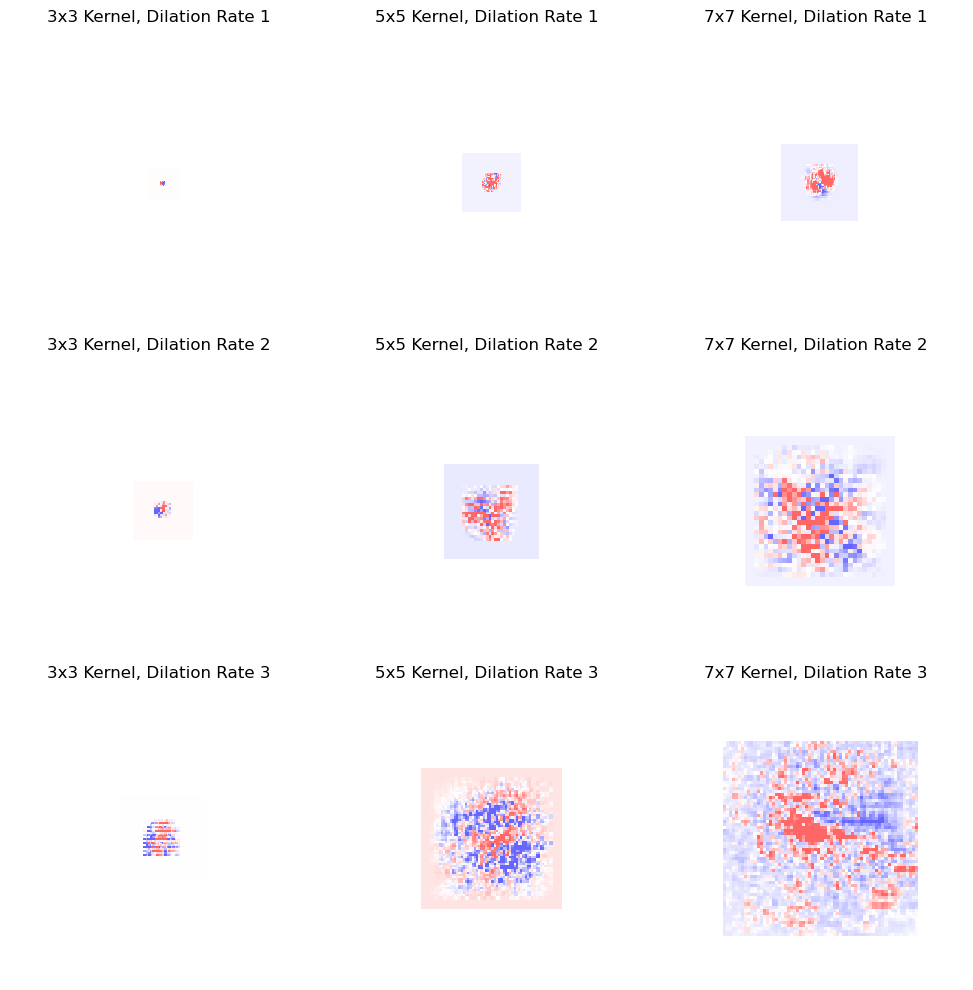

In [209]:
# Show kernels by themselves - no background image
fig, axs = plt.subplots(3,3,figsize=(10,10))
axs = np.array(axs)
for ax, settings, title in zip(axs.reshape(-1), combinations.values(), combinations.keys()):
    model = create_autoencoder((128,128,1),settings[0],settings[1],'g',num_filters = 2)
    img = model.predict(get_dummy_pad(settings[2]),verbose=0)[0,:,:,:]
    center = 135
    extent = (center-settings[2]*2,center+settings[2]*2,center-settings[2]*2,center+settings[2]*2)
    weights = model.layers[1].get_weights()[0].std()
    ax.imshow(np.ones_like(scaled),interpolation='none')
    ax.imshow(np.abs(img), cmap='bwr', vmin=img.mean()-img.std()*2, vmax=img.mean()+img.std()*2,alpha=0.6,interpolation='none', extent=extent)
    ax.imshow(np.zeros_like(scaled)[100:-100,100:-100],interpolation='none',alpha=0.0001)
    ax.set_title(title)
    ax.axis("off")
    ax.grid(True)

# fig.savefig('NovelMethod_32stack.png')
plt.tight_layout()
plt.show()

In [ ]:
new2 = np.zeros([100*100])
for x in range(new2.shape[0]):
    if x//100%2 == 0:
        if x%2==0:
            new2[x]=1
    # else:
    #     try:
    #         if x%2==0:
    #             new2[x+1]=1
    #     except:
    #         pass
new2=np.reshape(new2,[100,100])
real = np.real(fftshift(fft2(new2)))
keep_fraction = 0.4
# r, c = real.shape
# real[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0
# real[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0

plt.imshow(real,vmin=0,vmax=100)

In [ ]:
fig, axs = plt.subplots(3,3,figsize=FIGSIZE)
axs = np.array(axs)
for i in range(len(combinations2)):
    if combinations2[i][2]=='NovelMethod':
        combinations2.pop(i)
for ax, combo in zip(axs.reshape(-1),combinations2):
    model = autoencoder(combo[0],combo[1],combo[2])
    for iteration in range(30):
        if iteration == 0:
            out = model.predict(get_dummy(combo[3]),verbose=0)[0,:,:,0]
        else:
            out = np.add(out,model.predict(get_dummy(combo[3]),verbose=0)[0,:,:,0])
    new = np.zeros([out.shape[0]//8,out.shape[1]//8])
    for x in range(out.shape[0]):
        for y in range(out.shape[1]):
            if (x+1)%8 == 0 and (y+1)%8 == 0:
                new[x//8,y//8] = np.where(np.abs(out[x,y])>0.000001,1,0)
    real = np.real(fftshift(fft2(new)))
    # real[real.shape[0]//2,real.shape[1]//2]=0
    # real=np.where(real>10,real,0)
    keep_fraction = 0.4
    r, c = real.shape
    real[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0
    real[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0
    
    ax.imshow(real,vmin=0,vmax=100)
    ax.set_title(f"{combo[0]}x{combo[0]} Kernel, Dilation Rate {combo[1]}, Peak FFT: {np.round(np.max(real),1)}")
    ax.axis("off")
    ax.grid(True)
# fig.savefig('GlorotNormal_32stack_FFT.png')
    
    # sobel = np.add(scipy.ndimage.sobel(real),scipy.ndimage.sobel(real,0))
    # w = lat2W(sobel.shape[0],sobel.shape[1],rook=False)
    # mi = Moran(sobel,w)
    # print(combo,np.round(mi.I,3),mi.p_norm)
    # weights = model.layers[0].get_weights()[0].std()
    # extent = (175-combo[3]*4,175+combo[3]*4,175-combo[3]*4,175+combo[3]*4)
    # plt.imshow(real,cmap='bwr', vmin=-weights/(500/combo[0]**2),vmax=weights/(500/combo[0]**2),alpha=0.6,interpolation='none',extent=extent)
    # plt.title(combo)
    # plt.axis("off")
    # plt.grid(True)
    # plt.show();
    # input()

In [212]:
new = np.zeros([out.shape[0],out.shape[1]])
for x in range(out.shape[0]):
    for y in range(out.shape[1]):
        new[x,y] = np.where(np.abs(out[x,y])>0.5,1,0)

In [213]:
import matplotlib.colors as mcolors
red = [(1,0,0,c) for c in np.linspace(-1,1,100)]
cmap_red = mcolors.LinearSegmentedColormap.from_list('mycmap', red, N=5)

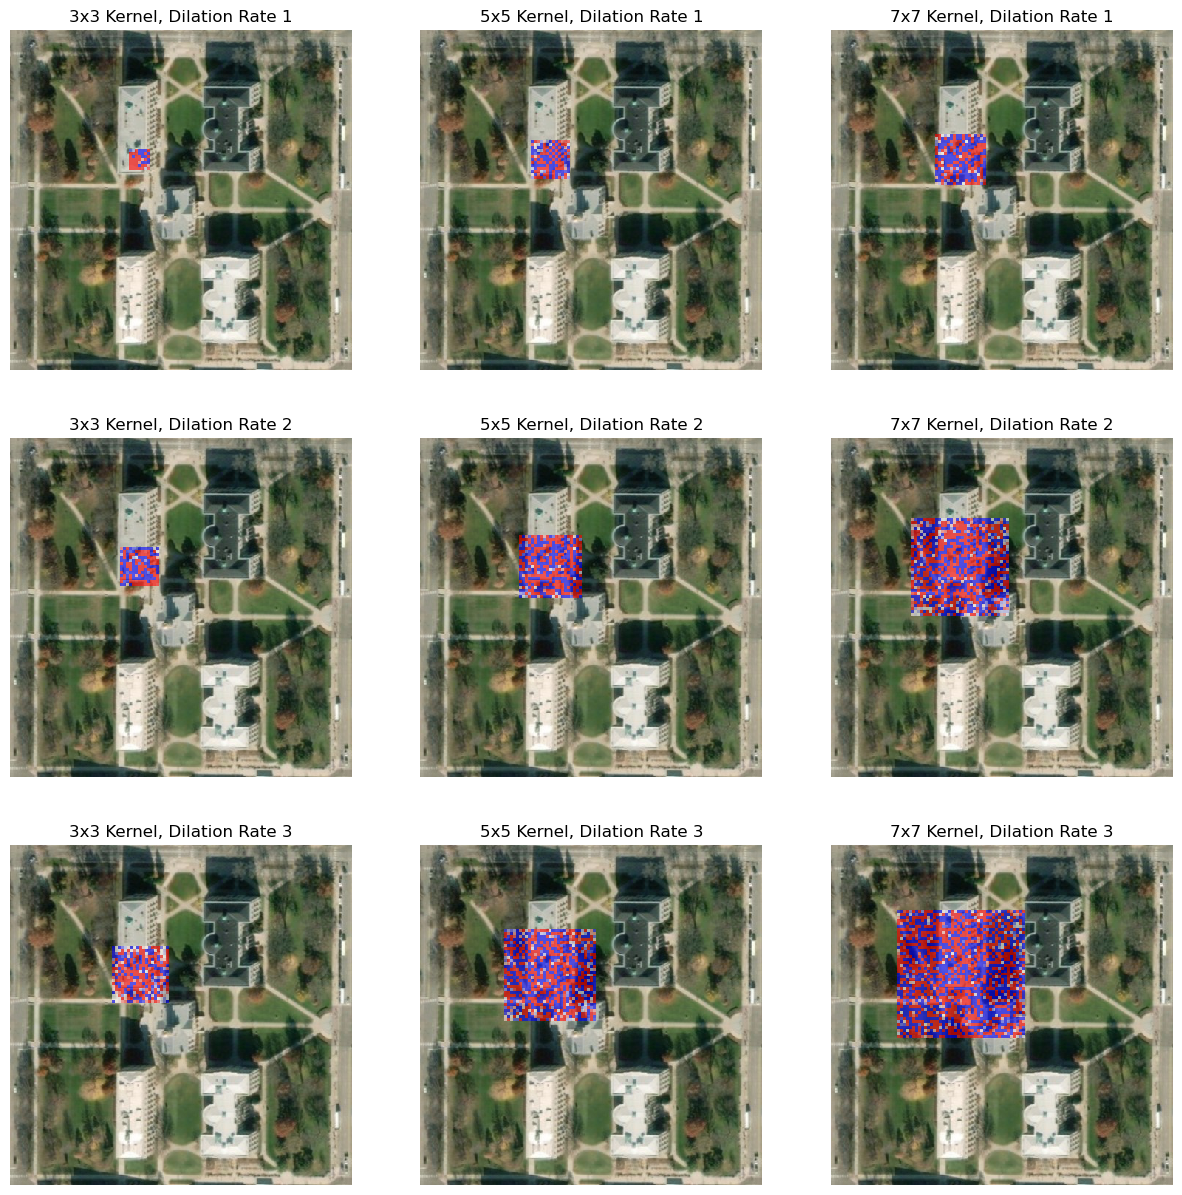

In [214]:
fig, axs = plt.subplots(3,3,figsize=FIGSIZE)
axs = np.array(axs)
for ax, settings, title in zip(axs.reshape(-1), combinations.values(), combinations.keys()):
    for iteration in range(32):
        model = autoencoder(settings[0],settings[1],'NovelMethod')
        if iteration == 0:
            img = model.predict(get_dummy(settings[2]),verbose=0)[0,:,:,:]
        else:
            img = np.add(img,model.predict(get_dummy(settings[2]),verbose=0)[0,:,:,:])
    extent = (175-settings[2]*2,175+settings[2]*2,175-settings[2]*2,175+settings[2]*2)
    weights = model.layers[0].get_weights()[0].std()
    ax.imshow(scaled,interpolation='none')
    ax.imshow(img,cmap='bwr', vmin=-weights/(500/settings[0]**2),vmax=weights/(500/settings[0]**2),alpha=0.6,interpolation='none',extent=extent)
    ax.imshow(scaled,interpolation='none',alpha=0.0001)
    ax.set_title(title)
    ax.axis("off")
    ax.grid(True)
# fig.savefig('NovelMethod_32stack.png')
plt.show()

In [ ]:
fig, axs = plt.subplots(3,3,figsize=FIGSIZE)
axs = np.array(axs)
for ax, settings, title in zip(axs.reshape(-1), combinations.values(), combinations.keys()):
    for iteration in range(32):
        model = autoencoder(settings[0],settings[1],'GlorotNormal')
        if iteration == 0:
            img = model.predict(get_dummy(settings[2]),verbose=0)[0,:,:,:]
        else:
            img = np.add(img,model.predict(get_dummy(settings[2]),verbose=0)[0,:,:,:])
    extent = (175-settings[2]*2,175+settings[2]*2,175-settings[2]*2,175+settings[2]*2)
    weights = model.layers[0].get_weights()[0].std()
    ax.imshow(scaled,interpolation='none')
    ax.imshow(img,cmap='bwr', vmin=-weights/(500/settings[0]**2),vmax=weights/(500/settings[0]**2),alpha=0.6,interpolation='none',extent=extent)
    ax.imshow(scaled,interpolation='none',alpha=0.0001)
    ax.set_title(title)
    ax.axis("off")
    ax.grid(True)
# fig.savefig('GlorotNormal_32stack.png')
plt.show()

In [ ]:
# fig, axs = plt.subplots(3,3,figsize=FIGSIZE)
# axs = np.array(axs)
# for ax, settings, title in zip(axs.reshape(-1), combinations.values(), combinations.keys()):
#     model = autoencoder(settings[0],settings[1],'RandomUniform')
#     img = model.predict(get_dummy(settings[2]),verbose=0)[0,:,:,:]
#     extent = (175-settings[2]*2,175+settings[2]*2,175-settings[2]*2,175+settings[2]*2)
#     weights = model.layers[0].get_weights()[0].std()
#     ax.imshow(scaled,interpolation='none')
#     ax.imshow(img,cmap='bwr', vmin=-weights/(500/settings[0]**2),vmax=weights/(500/settings[0]**2),alpha=0.6,interpolation='none',extent=extent)
#     ax.imshow(scaled,interpolation='none',alpha=0.0001)
#     ax.set_title(title)
#     ax.axis("off")
#     ax.grid(True)
# # fig.savefig('RandomUniform.png')
# # plt.show()